<a href="https://colab.research.google.com/github/maylad31/hopenet_colab/blob/main/Copy_of_part_swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#downloading weights
!pip install -U --no-cache-dir gdown --pre
%cd /content
!gdown --no-cookies 1oIrDYpKqadHta32SsDHf35olaPOCf57Z
!gdown ---no-cookies 1VB5punWxThhs39AsrPPGIBLzJBPlPFvm
!pip install pyyaml==5.4.1

/content
Downloading...
From: https://drive.google.com/uc?id=1VB5punWxThhs39AsrPPGIBLzJBPlPFvm
To: /content/vox-5segments.pth.tar
100% 728M/728M [00:06<00:00, 104MB/s] 


In [2]:
#cloning repos
!git clone https://github.com/AliaksandrSiarohin/motion-cosegmentation motion-co-seg
%cd motion-co-seg/
!git clone https://github.com/AliaksandrSiarohin/face-makeup.PyTorch face_parsing

Cloning into 'motion-co-seg'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 106 (delta 21), reused 13 (delta 13), pack-reused 74
Receiving objects: 100% (106/106), 42.61 MiB | 16.98 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [49]:
#imports
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")
import cv2
from part_swap import make_video, load_checkpoints, load_face_parser
from google.colab.patches import cv2_imshow

#load models

face_parser = load_face_parser(cpu=False)

reconstruction_module, segmentation_module = load_checkpoints(config='config/vox-256-sem-5segments.yaml', 
                                               checkpoint='/content/vox-5segments.pth.tar',
                                               blend_scale=1)
reconstruction_module1, segmentation_module1 = load_checkpoints(config='config/vox-256-sem-10segments.yaml', 
                                               checkpoint='/content/vox-first-order.pth.tar',
                                               blend_scale=0.125, first_order_motion_model=True)

Segmentation part initialized at random.


In [ ]:
#@title
def display(source, target, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(target)):
        cols = [source]
        cols.append(target[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani

**Visualizing the segmentation(use only for testing)**

In [ ]:
#@title
%matplotlib inline
import torch
import torch.nn.functional as F

import matplotlib.patches as mpatches


def visualize_segmentation(image, network, supervised=False, hard=True, colormap='gist_rainbow'):
    with torch.no_grad():
        inp = torch.tensor(image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2).cuda()
        if supervised:
            inp = F.interpolate(inp, size=(512, 512))
            inp = (inp - network.mean) / network.std
            mask = torch.softmax(network(inp)[0], dim=1)
            mask = F.interpolate(mask, size=image.shape[:2])
        else:
            mask = network(inp)['segmentation']
            mask = F.interpolate(mask, size=image.shape[:2], mode='bilinear')
    
    if hard:
        mask = (torch.max(mask, dim=1, keepdim=True)[0] == mask).float()
    
    colormap = plt.get_cmap(colormap)
    num_segments = mask.shape[1]
    mask = mask.squeeze(0).permute(1, 2, 0).cpu().numpy()
    color_mask = 0
    patches = []
    for i in range(num_segments):
        if i != 0:
            color = np.array(colormap((i - 1) / (num_segments - 1)))[:3]
        else:
            color = np.array((0, 0, 0))
        patches.append(mpatches.Patch(color=color, label=str(i)))
        color_mask += mask[..., i:(i+1)] * color.reshape(1, 1, 3)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))

    ax[0].imshow(color_mask)
    ax[1].imshow(0.3 * image + 0.7 * color_mask)
    ax[1].legend(handles=patches)
    ax[0].axis('off')
    ax[1].axis('off')

visualize_segmentation(source_image, segmentation_module, hard=True)
plt.show()

In [57]:

def make_predictions(img1,img2,reconstruction_module, segmentation_module,face_parser=None):
    """
    utility function to make predictions
    img1: str or bgr
    img2: str or bgr
    """
    if isinstance(img1, str):
        source_image = resize(cv2.imread(img1)[:,:,::-1], (256, 256))[..., :3]
    else:
        source_image = resize(img1[:,:,::-1], (256, 256))[..., :3]
    if isinstance(img2, str):
        target_video = [resize(frame, (256, 256))[..., :3] for frame in [cv2.imread(img2)[:,:,::-1],cv2.imread(img2)[:,:,::-1]]]
    else:
        target_video = [resize(frame, (256, 256))[..., :3] for frame in [img2[:,:,::-1],img2[:,:,::-1]]]
    if face_parser is None:
        predictions = make_video(swap_index=[2,1], source_image = source_image, target_video = target_video,
                             segmentation_module=segmentation_module, reconstruction_module=reconstruction_module)
    else:
        predictions =  make_video(swap_index=[2, 3, 4, 5, 6, 7,12,13], source_image = source_image,
                         target_video = target_video, use_source_segmentation=True, segmentation_module=segmentation_module,
                         reconstruction_module=reconstruction_module, face_parser=face_parser)
#HTML(display(source_image, target_video, predictions).to_html5_video())
    predictions[0]=predictions[0]*255
    
    return predictions[0][:,:,::-1]
#

100%|██████████| 2/2 [00:00<00:00, 12.84it/s]


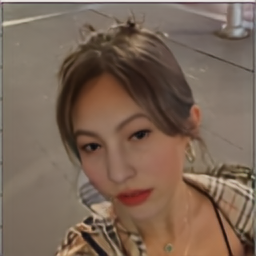

In [66]:


def final_pred(avatar="/content/download1.png",person="/content/download.png"):
    """
    main function to call
    avatar: str or bgr
    person: str or bgr
    """
    pred=make_predictions(avatar,person,reconstruction_module, segmentation_module)
    pred=pred/255
    pred=make_predictions(person,pred,reconstruction_module1, segmentation_module1,face_parser)
    return pred
    
pred=final_pred(avatar="/content/download1.png",person="/content/download.png")
cv2_imshow(pred)
